In [1]:
import json
import os
import requests
import datetime

In [2]:
from dateutil.parser import parse as date_parse

In [3]:
from imp import reload

In [4]:
import auth
import truth_analysis as ta

In [158]:
reload(ta)

<module 'truth_analysis' from '/Users/gkeramidas/Projects/leo-backend-od/truth_analysis.py'>

## Initialize orekit and LL_od

In [11]:
from od_init import initialize_leolabs_od

In [12]:
initialize_leolabs_od()

In [31]:
import orekit

In [32]:
orekit_vm = orekit.initVM()

## Functions to pull data from API and transform them into container classes for use in truth analysis

In [13]:
def id_data(leo_id):
    """ID Data for a LeoLabs object to initialize the truth analysis object."""
    object_url = "".join([auth.api_url, '/catalog/objects/',leo_id])
    object_response = requests.get(object_url,headers=auth.headers)
    leolabs_id = object_response.json()["catalogNumber"] 
    norad_id = object_response.json()["noradCatalogNumber"]
    name = object_response.json()["name"]
    
    id_dict = {}
    id_dict['leolabs_id'] = leolabs_id
    id_dict['norad_id'] = norad_id
    id_dict['object_name'] = name
    return id_dict

In [14]:
id_data_L5011 = id_data('L5011')

In [15]:
def state_data(leo_id, start_date, end_date):
    """Pull all the states of a LeoLabs object between certain dates"""
    start_time = datetime.datetime(start_date[0], start_date[1], start_date[2]).strftime("%Y-%m-%d")
    end_time = datetime.datetime(end_date[0], end_date[1], end_date[2]).strftime("%Y-%m-%d")
    
    states_url = "".join([auth.api_url, '/catalog/objects/',leo_id,'/states?startTime=',start_time,'&endTime=',end_time])
    
    states_response = requests.get(states_url,headers=auth.headers)
    
    first_state_id = states_response.json()["states"][0]["id"]
    
    return states_response 

In [16]:
def RIC_covariance_of_propagations(leo_id, state_id, start_date, end_date, timestep):
    """Pull the RIC covariances out of the propagations """ 
    start_time = datetime.datetime(start_date[0], start_date[1], start_date[2]).strftime("%Y-%m-%d")
    end_time = datetime.datetime(end_date[0], end_date[1], end_date[2]).strftime("%Y-%m-%d")
    
    prop_with_ric_url = "".join([auth.api_url, '/catalog/objects/',leo_id,'/states/',ST0_ID,'/propagations?startTime=',start_time,'&endTime=',end_time,'&timestep=',str(timestep),'&frame=RIC'])
    
    prop_with_ric_response = requests.get(prop_with_ric_url, headers=auth.headers)
    
    return prop_with_ric_response.json()["propagation"]

In [17]:
def propagation_of_state(leo_id, state_id, start_date, end_date, timestep):
    """Request state propagations between a start date and an end date and with certain timestep."""
    start_time = datetime.datetime(start_date[0], start_date[1], start_date[2]).strftime("%Y-%m-%d")
    end_time = datetime.datetime(end_date[0], end_date[1], end_date[2]).strftime("%Y-%m-%d")
    
    propagation_url = "".join([auth.api_url, '/catalog/objects/',leo_id,'/states/',ST0_ID,'/propagations?startTime=',start_time,'&endTime=',end_time,'&timestep=',str(timestep)])
    
    propagation_response = requests.get(propagation_url, headers=auth.headers)
    
    return propagation_response.json()["propagation"]

In [18]:
class PropagationsContainer():
    """Convenience container for propagations"""
    
    def __init__(self,timestamp,position,velocity,covariance):
        self.timestamp = timestamp
        self.position = position
        self.velocity = velocity
        self.covariance = covariance

In [76]:
class RicCovariancesContainer():
    """Convenience container for RIC covariances"""
    
    def __init__(self,covariance):
        self.covariance = covariance

In [84]:
def Ric_propagation_dict_to_container(ric_prop_dict):
    """Takes a single RIC propagation json dictionary and returns a RicCovariancesContainer object."""
    
    covariance = ric_prop_dict['covariance']
    
    return RicCovariancesContainer(covariance)

In [19]:
def propagation_dict_to_container(prop_dict):
    """Takes a single propagation list and returns a PropagationsContainer object."""
    
    timestamp = date_parse(prop_dict['timestamp'],ignoretz=True )
    position = prop_dict['position']
    velocity = prop_dict['velocity']
    covariance = prop_dict['covariance']
    
    return PropagationsContainer(timestamp,position,velocity,covariance)

In [20]:
def propagations_list(propagations_dict):
    """Takes a propagations dict and returns a list with PropagationContainer objects."""
    
    prop_list = []
    for i in range(len(propagations_dict)):
        prop_list.append(propagation_dict_to_container(propagations_dict[i]))
    
    return prop_list

In [91]:
def RIC_Covariances_list(ric_dict):
    """Takes a RIC propagations dict and returns a list of RicCovariancesContainer object."""
    
    ric_list = []
    for i in range(len(ric_dict)):
        ric_list.append(Ric_propagation_dict_to_container(ric_dict[i]).covariance)
        
    return ric_list

In [92]:
SD = state_data('L5011',[2022,2,3],[2022,2,5])

In [93]:
ST0_ID = str(SD.json()["states"][0]["id"])

In [143]:
propagation_test = propagation_of_state('L5011',ST0_ID,[2022,2,3],[2022,2,8],1000)

In [144]:
propagations_test_list = propagations_list(propagation_test)

In [145]:
ric_covariance_L5011 = RIC_covariance_of_propagations('L5011',ST0_ID,[2022,2,3],[2022,2,8],1000)

In [146]:
ric_covariances_test_list = RIC_Covariances_list(ric_covariance_L5011)

In [159]:
L5011_TO = ta.TruthAnalysis(id_data_L5011,propagations_test_list,ric_covariances_test_list)

## Bring here the orekit DataProviderManager

In [157]:
import sys

In [53]:
def use_config_directory(config_directory):
    from java.io import File

    from org.orekit.data import DirectoryCrawler
    from org.orekit.data import DataProvidersManager

    #data_manager = DataProvidersManager.getInstance()
    data_manager = DataProvidersManager()
    data_crawler = DirectoryCrawler(File(config_directory))

    data_manager.clearProviders()
    data_manager.addProvider(data_crawler)

    # Orekit custom class for NRLMSISE00 parameters needs this for now
    os.environ['LL_DYN_CONFIG_DIR'] = config_directory

In [54]:
os.environ['LL_DYN_CONFIG_LOCATION']

'/Users/gkeramidas/Projects/learning/'

In [55]:
os.environ['LL_DYN_CONFIG_DIR']

'/Users/gkeramidas/Projects/learning/leolabs-config-data-dynamic'

In [56]:
use_config_directory('/Users/gkeramidas/Projects/learning/leolabs-config-data-dynamic')

In [57]:
from org.orekit.time import TimeScalesFactory

In [68]:
from orekit.pyhelpers import  setup_orekit_curdir

In [69]:
setup_orekit_curdir("/Users/gkeramidas/Projects/learning/leolabs-config-data-dynamic/")

In [70]:
TimeScalesFactory.addDefaultUTCTAIOffsetsLoaders()

In [71]:
TimeScalesFactory.getUTC()

<UTCScale: UTC>

## Run Truth Analysis

In [160]:
norm_errors_dict, dist_list = L5011_TO.ilrs_truth_analysis()

info Syncing ILRS truth data from S3 (17 files downloaded)
info Truth data reader assembled (1.1362910270690918 seconds elapsed)


In [111]:
def extract_epochOffset(norm_errors_dict):
    """Takes a dictionary with normalized errors and extracts the epoch Offset and returns them into a list"""
    
    epoch_Offset_list = []
    
    for i in range(len(norm_errors_dict)):
        epoch_Offset_list.append(norm_errors_dict[i]['epochOffset'])
    
    return epoch_Offset_list

In [161]:
epoch_Offset = extract_epochOffset(norm_errors_dict)

In [150]:
def extract_norm_error(norm_errors_dict, coord_ind):
    """Takes a dictionary with normalized errors and extracts any of the errors, based on the coord_ind"""
    
    error_list = []
    
    for i in range(len(norm_errors_dict)):
        error_list.append(norm_errors_dict[i]['vals'][coord_ind])
        
    return error_list

In [162]:
r_err = extract_norm_error(norm_errors_dict,0)
i_err = extract_norm_error(norm_errors_dict,1)
c_err = extract_norm_error(norm_errors_dict,2)
vr_err = extract_norm_error(norm_errors_dict,3)
vi_err = extract_norm_error(norm_errors_dict,4)
vc_err = extract_norm_error(norm_errors_dict,5)

In [119]:
from matplotlib import pyplot as plt

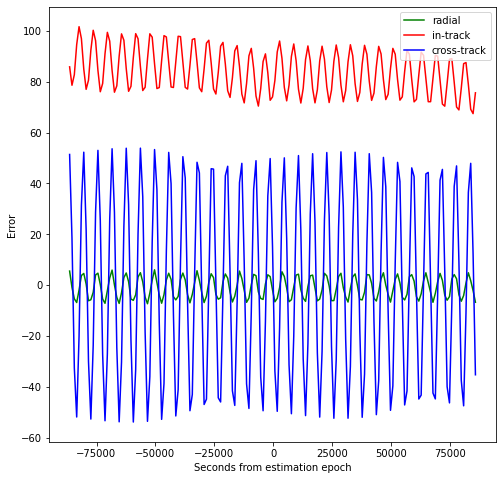

In [163]:
plt.figure(figsize=(8,8))
plt.plot(epoch_Offset,r_err,'g',label='radial')
plt.plot(epoch_Offset,i_err,'r',label='in-track')
plt.plot(epoch_Offset,c_err,'b',label='cross-track')
plt.legend(loc='upper right')
plt.xlabel('Seconds from estimation epoch')
plt.ylabel('Error')
plt.show()

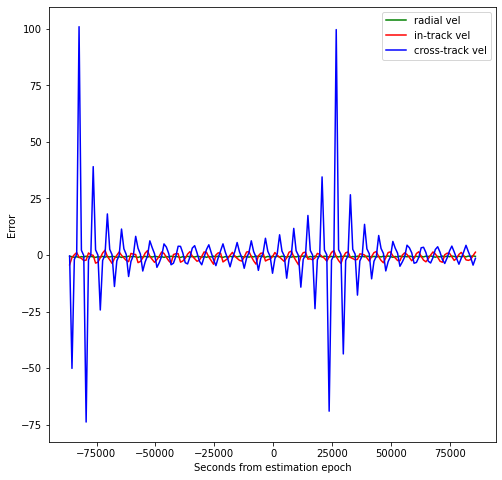

In [153]:
plt.figure(figsize=(8,8))
plt.plot(epoch_Offset,vr_err,'g',label='radial vel')
plt.plot(epoch_Offset,vi_err,'r',label='in-track vel')
plt.plot(epoch_Offset,vc_err,'b',label='cross-track vel')
plt.legend(loc='upper right')
plt.xlabel('Seconds from estimation epoch')
plt.ylabel('Error')
plt.show()

In [1]:
dist_list.shape

NameError: name 'dist_list' is not defined